# Assignment 2: Pneumonia Detection
for module COMP47590: Advanced Machine Learning

Author(s): Arlene John and Vitoria Fahed



## Import Packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import random
import copy

import csv
import os 
import cv2
import scipy as sp
import PIL
from PIL import Image

from IPython.display import display, HTML, SVG

import sklearn
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing 
from sklearn.metrics import hamming_loss,make_scorer, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Task 1 - Load the dataset

In [2]:
dataset_name = 'chest_xray'

# data divided into train and test set
train_data_dir = dataset_name + '/train/'
test_data_dir = dataset_name + '/test/'

sample_rate = 1.0

# resizing the images
img_width, img_height = 162, 128

# parameters obtained from Jupyter Notebooks provided by module coordinator during the module
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [3]:
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')]
num_classes = len(training_class_folders)

X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data = np.ndarray(0, dtype=np.str)
    
for i, image_cls in enumerate(training_class_folders):
    
    print('Class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')]
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    for i, image_file in enumerate(image_filenames):

        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]]
        
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        X_data_part[i] = image
        #X_data_part[i] = X_data_part[i]/255
        
        y_data = np.append(y_data, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    X_data = np.append(X_data, X_data_part, axis=0)
    
print("Data shape: {}".format(X_data.shape))

Class NORMAL
Processed 0 of 1349 for class NORMAL 
Processed 100 of 1349 for class NORMAL 
Processed 200 of 1349 for class NORMAL 
Processed 300 of 1349 for class NORMAL 
Processed 400 of 1349 for class NORMAL 
Processed 500 of 1349 for class NORMAL 
Processed 600 of 1349 for class NORMAL 
Processed 700 of 1349 for class NORMAL 
Processed 800 of 1349 for class NORMAL 
Processed 900 of 1349 for class NORMAL 
Processed 1000 of 1349 for class NORMAL 
Processed 1100 of 1349 for class NORMAL 
Processed 1200 of 1349 for class NORMAL 
Processed 1300 of 1349 for class NORMAL 
Processed 1349 of 1349 for class NORMAL 
Class PNEUMONIA
Processed 0 of 3883 for class PNEUMONIA 
Processed 100 of 3883 for class PNEUMONIA 
Processed 200 of 3883 for class PNEUMONIA 
Processed 300 of 3883 for class PNEUMONIA 
Processed 400 of 3883 for class PNEUMONIA 
Processed 500 of 3883 for class PNEUMONIA 
Processed 600 of 3883 for class PNEUMONIA 
Processed 700 of 3883 for class PNEUMONIA 
Processed 800 of 3883 for 

In [4]:
test_class_folders = [i for i in os.listdir(test_data_dir) if not i.startswith('.')]
num_classes = len(test_class_folders)

X_test = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_test = np.ndarray(0, dtype=np.str)
    
for i, image_cls in enumerate(test_class_folders):
    
    print('Class {}'.format(image_cls))
    image_class_folder = test_data_dir + image_cls + "/"

    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')]
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    count = len(image_filenames)
    X_test_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    for i, image_file in enumerate(image_filenames):

        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]]
        
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        X_test_part[i] = image
        #X_test_part[i] = X_test_part[i]/255
        
        y_test = np.append(y_test, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    X_test = np.append(X_test, X_test_part, axis=0)
    
print("Data shape: {}".format(X_test.shape))

Class NORMAL
Processed 0 of 234 for class NORMAL 
Processed 100 of 234 for class NORMAL 
Processed 200 of 234 for class NORMAL 
Processed 234 of 234 for class NORMAL 
Class PNEUMONIA
Processed 0 of 390 for class PNEUMONIA 
Processed 100 of 390 for class PNEUMONIA 
Processed 200 of 390 for class PNEUMONIA 
Processed 300 of 390 for class PNEUMONIA 
Processed 390 of 390 for class PNEUMONIA 
Data shape: (624, 162, 128, 3)


Print some of the images

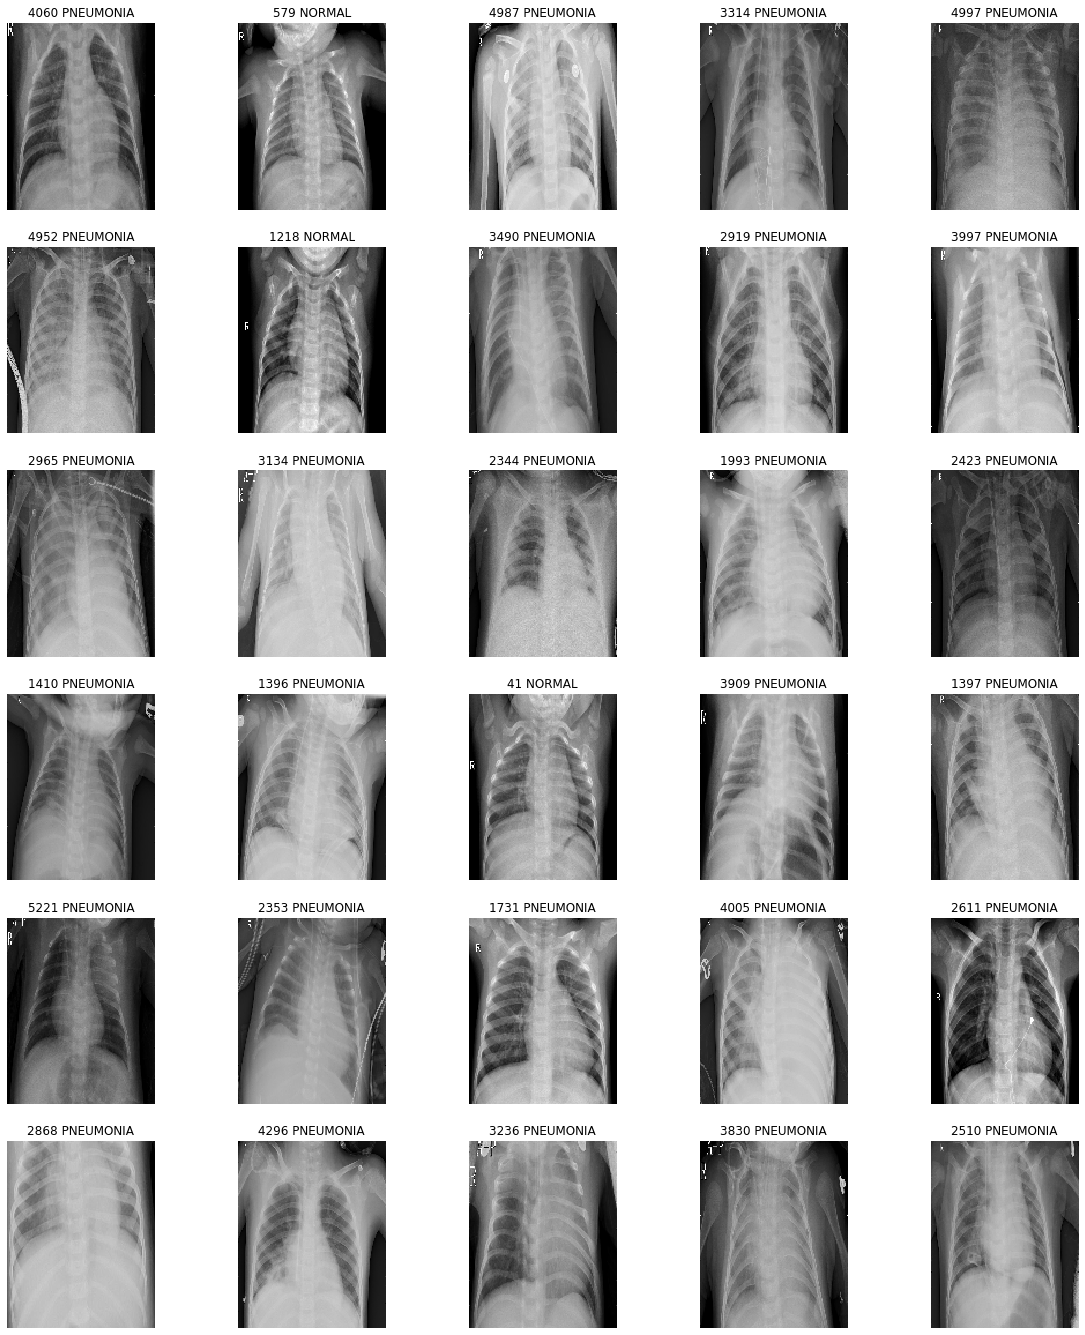

In [5]:
pltsize=4
row_images = 6
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_data.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(Image.fromarray(X_data[i_rand].astype(np.uint8)))
    plt.title((str(i_rand) + " " + y_data[i_rand]))

Split the trainnig set into trainning and validation set

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, random_state=0, test_size = 0.2, train_size = 0.8)

In [7]:
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

y_data_num = y_train_encoder.fit_transform(y_data)
y_data_wide = keras.utils.to_categorical(y_data_num, num_classes)

In [8]:
classes_num_label = dict()
classes_num_label

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

Creating a dataframe to store the values of the evaluation scores to better compare them for the test set

In [9]:
initialize = np.zeros(shape=4)
df = pd.DataFrame({'Logistic Regression':initialize , 'LeNet with Undersampling':initialize , 'LeNet with Data Augmentation':initialize , 'VGG-16':initialize}, index=['Accuracy','Precision','Recall','F1-score'])
df

Logistic Regression  LeNet with Undersampling  \
Accuracy                   0.0                       0.0   
Precision                  0.0                       0.0   
Recall                     0.0                       0.0   
F1-score                   0.0                       0.0   

           LeNet with Data Augmentation  VGG-16  
Accuracy                            0.0     0.0  
Precision                           0.0     0.0  
Recall                              0.0     0.0  
F1-score                            0.0     0.0

## Task 2 - Logistic Regression Model

Converting the images to greyscale

In [10]:
def rgb2gray(rgb):
    gray=np.zeros((rgb.shape[0],rgb.shape[1],rgb.shape[2]))
    for i in range(rgb.shape[0]):
        swap_image=img = np.array(rgb[i,:,:,:], dtype=np.uint8)
        gray[i,:,:] = cv2.cvtColor(swap_image, cv2.COLOR_BGR2GRAY)
    #gray = (r + g + b)/3
    gray = gray/255
    return gray

In [11]:
X_train_gray = rgb2gray(X_train)

In [12]:
X_valid_gray = rgb2gray(X_valid)

In [13]:
X_test_gray = rgb2gray(X_test)

In [14]:
X_data_gray = rgb2gray(X_data)

Print some of the grayscale images

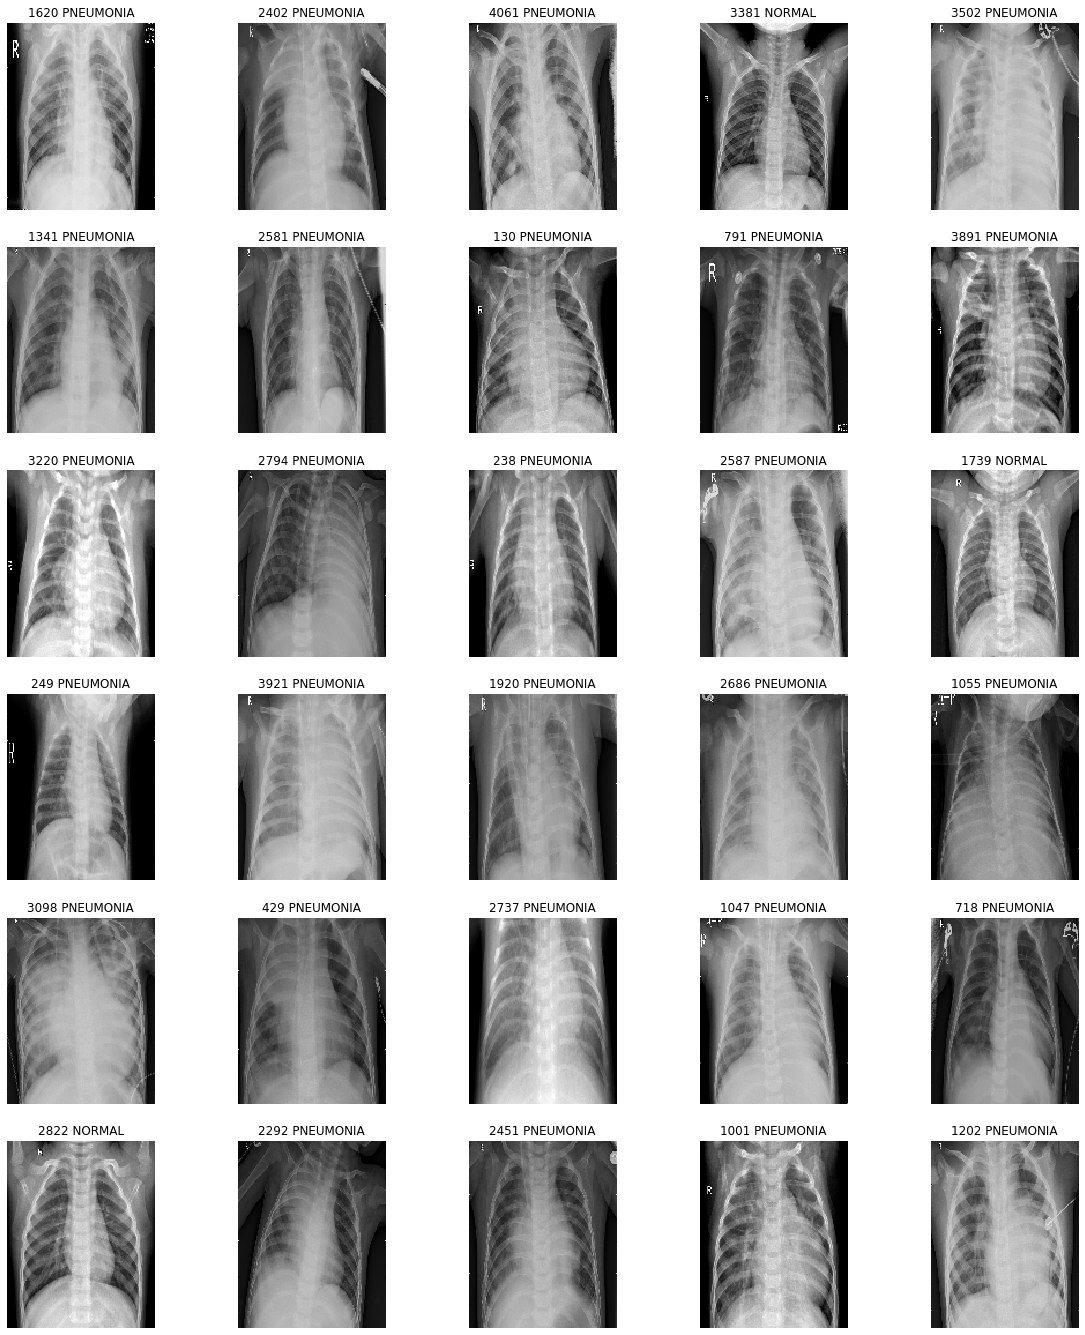

In [15]:
pltsize=4
row_images = 6
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(X_train_gray[i_rand]*255,cmap='gray')
    plt.title((str(i_rand) + " " + y_train[i_rand]))

In [16]:
print(y_train_num.shape, X_valid_gray.shape)

(4185,) (1047, 162, 128)


Reshaping the images to fit the Logistic Regression Model

In [17]:
xsample, dim1, dim2 = X_train_gray.shape
X_train_2d = X_train_gray.reshape((xsample,dim1*dim2))

xsample, dim1, dim2 = X_valid_gray.shape
X_valid_2d = X_valid_gray.reshape((xsample,dim1*dim2))

xsample, dim1, dim2 = X_test_gray.shape
X_test_2d = X_test_gray.reshape((xsample,dim1*dim2))

Train the model with the training set

In [18]:
our_model = linear_model.LogisticRegression(max_iter=1000)
our_model.fit(X_train_2d, y_train_num)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluation

Evaluate the model with the validation set

In [19]:
predict_valid_lr = our_model.predict(X_valid_2d)

In [20]:
accuracy_valid_lr = accuracy_score(y_valid_num, predict_valid_lr)
print("Accuracy: " +  str(accuracy_valid_lr))
print(metrics.classification_report(y_valid_num, predict_valid_lr))
print(metrics.confusion_matrix(y_valid_num, predict_valid_lr))

Accuracy: 0.9541547277936963
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       276
           1       0.97      0.97      0.97       771

    accuracy                           0.95      1047
   macro avg       0.94      0.94      0.94      1047
weighted avg       0.95      0.95      0.95      1047

[[249  27]
 [ 21 750]]


Evaluate the model with the test set

In [21]:
predict_test_lr = our_model.predict(X_test_2d)

In [22]:
accuracy_test_lr = accuracy_score(y_test_num, predict_test_lr)
report_lr = metrics.classification_report(y_test_num, predict_test_lr, output_dict=True)
print("Accuracy: " +  str(accuracy_test_lr))
print(metrics.classification_report(y_test_num, predict_test_lr))
print(metrics.confusion_matrix(y_test_num, predict_test_lr))

Accuracy: 0.7451923076923077
              precision    recall  f1-score   support

           0       0.95      0.34      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.66      0.66       624
weighted avg       0.80      0.75      0.71       624

[[ 79 155]
 [  4 386]]


Print some examples of correctly classified images

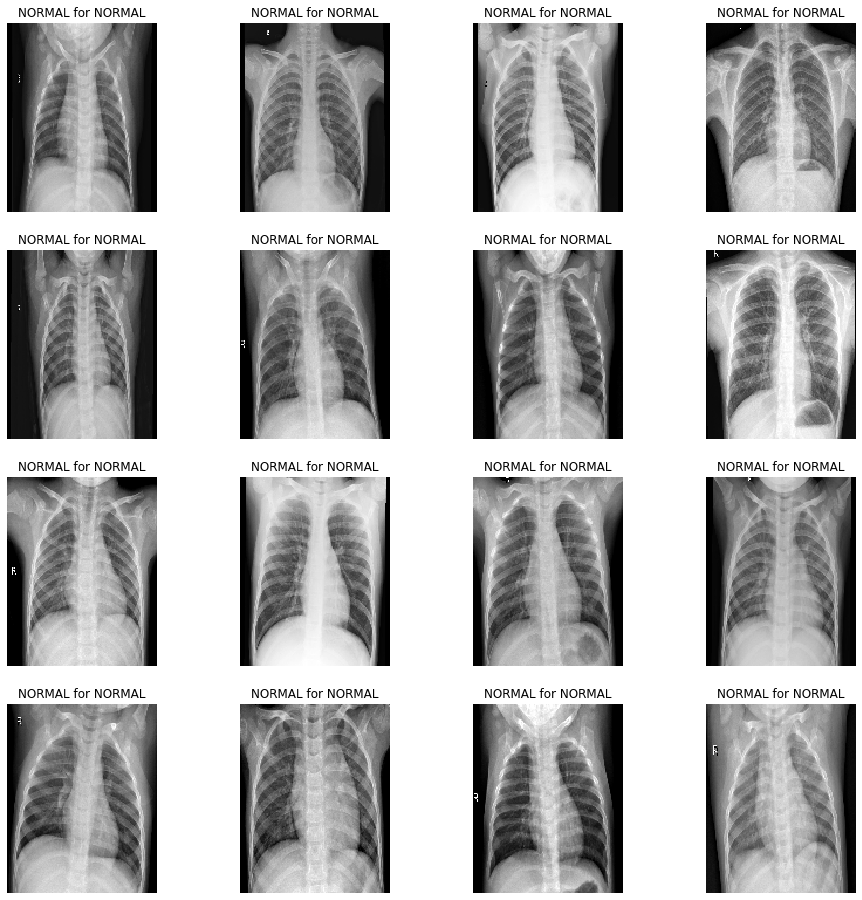

In [23]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_lr.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_gray.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test_gray[i],cmap='gray')
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

Print some examples of miscalssified images

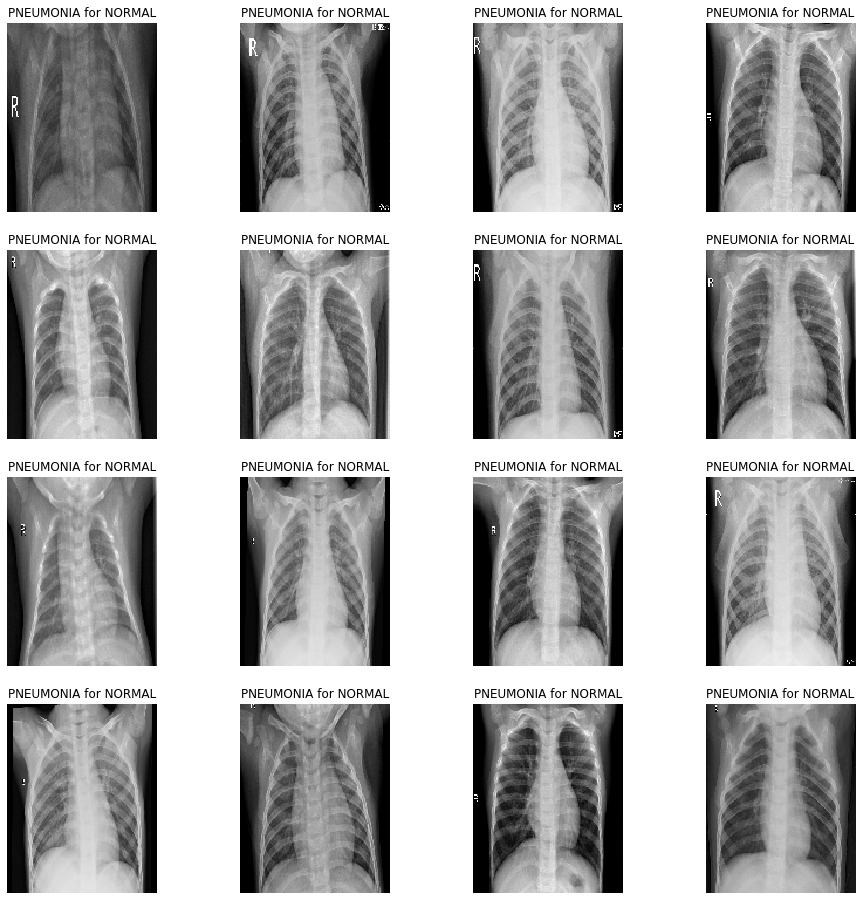

In [24]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_lr.reshape(-1)
corrects = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_gray.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test_gray[i],cmap='gray')
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

In [25]:
df['Logistic Regression']['Accuracy'] = accuracy_test_lr
df['Logistic Regression']['Precision'] = report_lr['macro avg']['precision']
df['Logistic Regression']['Recall'] = report_lr['macro avg']['recall']
df['Logistic Regression']['F1-score'] = report_lr['macro avg']['f1-score']

In [26]:
df

Logistic Regression  LeNet with Undersampling  \
Accuracy              0.745192                       0.0   
Precision             0.832650                       0.0   
Recall                0.663675                       0.0   
F1-score              0.663819                       0.0   

           LeNet with Data Augmentation  VGG-16  
Accuracy                            0.0     0.0  
Precision                           0.0     0.0  
Recall                              0.0     0.0  
F1-score                            0.0     0.0

## Task 3 - Convolutional Neural Network

### Imbalance in the Dataset

In [27]:
normal_indices = np.where(y_data_num ==0)[0]

In [28]:
pneumonia_indices = np.where(y_data_num != 0)[0]

To handle the imbalance in the dataset, undersampling was performed

In [29]:
#downsampling the majority class
if pneumonia_indices.shape[0]>normal_indices.shape[0]:
    new_pneumonia_indices = np.random.choice(pneumonia_indices,normal_indices.shape[0])
    new_normal_indices = normal_indices
else:
    new_normal_indices = np.random.choice(normal_indices,pneumonia_indices.shape[0])
    new_pneumonia_indices = pneumonia_indices

In [30]:
y_resampled_data = y_data_num[new_normal_indices]
y_resampled_data = np.append(y_resampled_data,y_data_num[new_pneumonia_indices],axis=0)

In [31]:
y_resampled_data_wide = y_data_wide[new_normal_indices]
y_resampled_data_wide = np.append(y_resampled_data_wide,y_data_wide[new_pneumonia_indices],axis=0)

In [32]:
X_resampled_data_rgb = X_data[new_normal_indices]
X_resampled_data_rgb = np.append(X_resampled_data_rgb,X_data[new_pneumonia_indices],axis=0)

In [33]:
X_resampled_data_rgb = X_resampled_data_rgb/255 #normalize
X_test = X_test/255

In [34]:
X_resampled_data_gray = X_data_gray[new_normal_indices]
X_resampled_data_gray = np.append(X_resampled_data_gray,X_data_gray[new_pneumonia_indices],axis=0)

### LeNet-5 Model architecture

In [35]:
keras.backend.clear_session()

In [36]:
X_resampled_data_gray.shape 

(2698, 162, 128)

In [37]:
X_resampled_data_gray_lenet = X_resampled_data_gray.reshape(2698,162,128,1)

In [38]:
lenet_model = Sequential()
lenet_model.add(Conv2D(6, (5, 5),input_shape=(162,128,1)))
lenet_model.add(Activation('relu'))
lenet_model.add(AveragePooling2D(pool_size=(2, 2), strides=2))

lenet_model.add(Conv2D(16, (5,5)))
lenet_model.add(Activation('relu'))
lenet_model.add(AveragePooling2D(pool_size=(2, 2), strides=2))

lenet_model.add(Conv2D(120, (5,5)))
lenet_model.add(Activation('relu'))

lenet_model.add(Flatten())
lenet_model.add(Dense(84))
lenet_model.add(Activation('relu'))
lenet_model.add(Dropout(0.5))
lenet_model.add(Dense(num_classes))
lenet_model.add(Activation('softmax'))

lenet_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 158, 124, 6)       156       
_________________________________________________________________
activation_1 (Activation)    (None, 158, 124, 6)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 58, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 75, 58, 16)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 37, 29, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 25, 120)      

In [39]:
batch_size = 128
epochs = 200

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_lenet5.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = lenet_model.fit(X_resampled_data_gray_lenet, y_resampled_data_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
lenet_model.load_weights(best_weights_filepath)

Train on 2158 samples, validate on 540 samples
Epoch 1/200
2158/2158 [==============================] - 10s 5ms/step - loss: 0.6477 - accuracy: 0.6645 - val_loss: 0.6181 - val_accuracy: 0.6981
Epoch 2/200
2158/2158 [==============================] - 10s 5ms/step - loss: 0.2753 - accuracy: 0.8846 - val_loss: 0.2455 - val_accuracy: 0.9130
Epoch 3/200
2158/2158 [==============================] - 10s 5ms/step - loss: 0.2200 - accuracy: 0.9175 - val_loss: 0.1716 - val_accuracy: 0.9296
Epoch 4/200
2158/2158 [==============================] - 10s 5ms/step - loss: 0.1724 - accuracy: 0.9365 - val_loss: 0.3286 - val_accuracy: 0.8907
Epoch 5/200
2158/2158 [==============================] - 10s 5ms/step - loss: 0.1281 - accuracy: 0.9518 - val_loss: 0.1938 - val_accuracy: 0.9315
Epoch 6/200
2158/2158 [==============================] - 11s 5ms/step - loss: 0.1184 - accuracy: 0.9527 - val_loss: 0.0742 - val_accuracy: 0.9704
Epoch 7/200
2158/2158 [==============================] - 10s 5ms/step - loss:

#### Evaluation

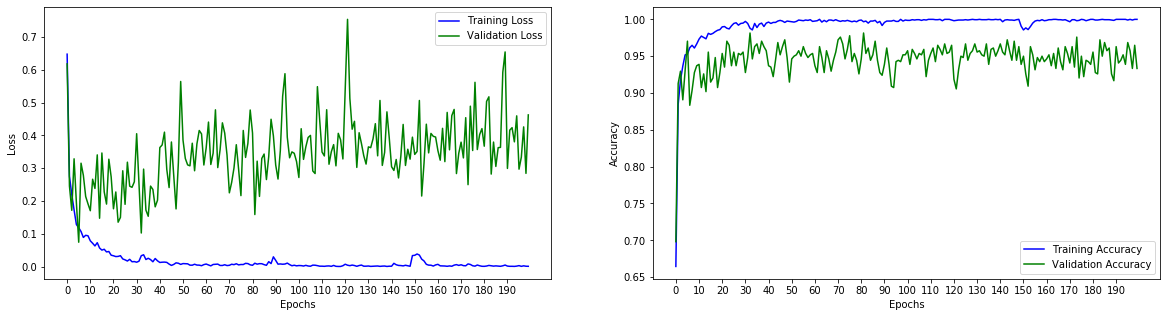

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::10])
plt.legend()

plt.subplot(1,2,2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, 'blue', label='Training Accuracy')
plt.plot(val_acc, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::10])
plt.legend()

plt.show()

In [41]:
#Show performance on the training set
predict_train_ln = lenet_model.predict_classes(X_resampled_data_gray_lenet)  
accuracy_train_ln = accuracy_score(y_resampled_data, predict_train_ln)
report_train_ln = metrics.classification_report(y_resampled_data, predict_train_ln, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_train_ln)
print(' ')
print(metrics.classification_report(y_resampled_data, predict_train_ln))
print("Confusion matrix")
print(metrics.confusion_matrix(y_resampled_data, predict_train_ln))

Accuracy:  0.9403261675315048
 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1349
           1       0.91      0.98      0.94      1349

    accuracy                           0.94      2698
   macro avg       0.94      0.94      0.94      2698
weighted avg       0.94      0.94      0.94      2698

Confusion matrix
[[1211  138]
 [  23 1326]]


In [43]:
X_test_gray_lenet = X_test_gray.reshape(624,162,128,1)

In [44]:
predict_test_ln = lenet_model.predict_classes(X_test_gray_lenet)

accuracy_test_ln = accuracy_score(y_test_num, predict_test_ln)
report_ln = metrics.classification_report(y_test_num, predict_test_ln, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_test_ln)
print(' ')
print(metrics.classification_report(y_test_num, predict_test_ln))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, predict_test_ln))

Accuracy:  0.7339743589743589
 
              precision    recall  f1-score   support

           0       0.95      0.31      0.46       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.65      0.64       624
weighted avg       0.80      0.73      0.69       624

Confusion matrix
[[ 72 162]
 [  4 386]]


Print a few examples of correctly classified images

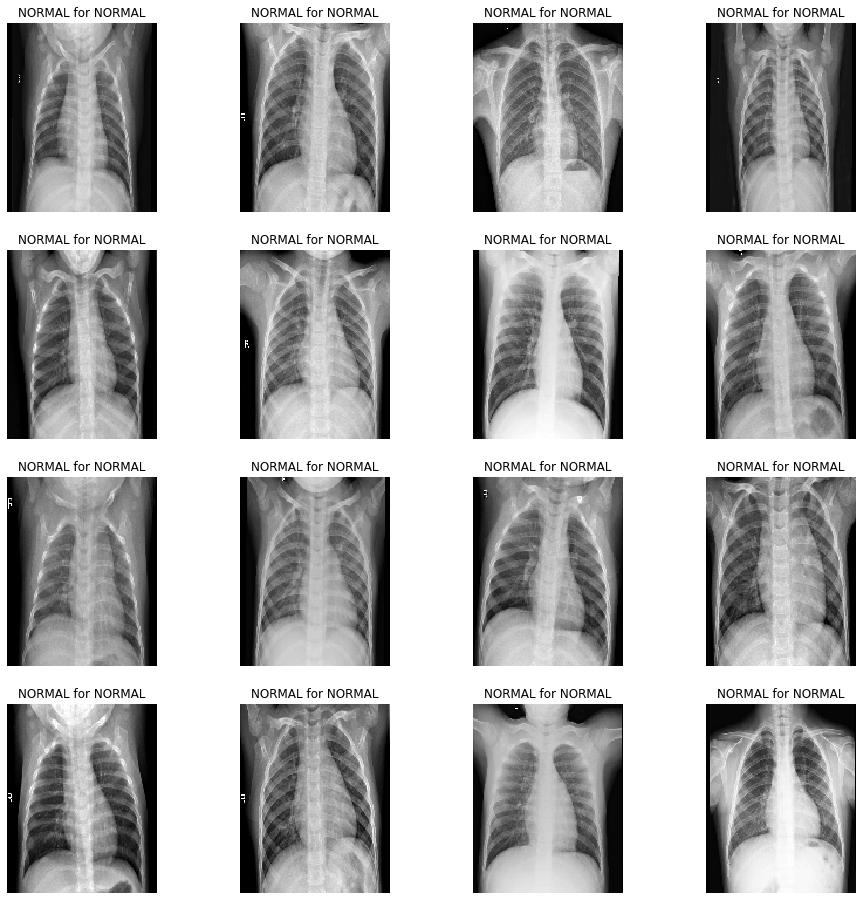

In [45]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_ln.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_gray.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test_gray[i],cmap='gray')
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

Print a few examples of misclassified images

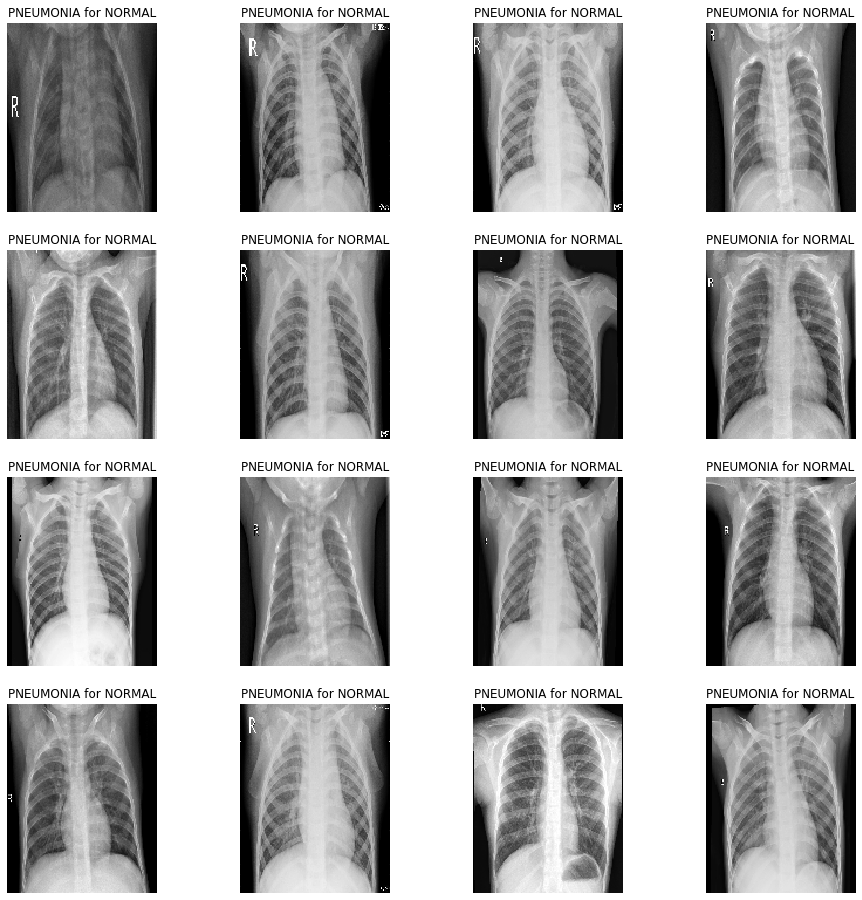

In [46]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_ln.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_gray.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test_gray[i]*255,cmap='gray')
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

In [47]:
df['LeNet with Undersampling']['Accuracy'] = accuracy_test_ln
df['LeNet with Undersampling']['Precision'] = report_ln['macro avg']['precision']
df['LeNet with Undersampling']['Recall'] = report_ln['macro avg']['recall']
df['LeNet with Undersampling']['F1-score'] = report_ln['macro avg']['f1-score']

In [48]:
df

Logistic Regression  LeNet with Undersampling  \
Accuracy              0.745192                  0.733974   
Precision             0.832650                  0.825874   
Recall                0.663675                  0.648718   
F1-score              0.663819                  0.643772   

           LeNet with Data Augmentation  VGG-16  
Accuracy                            0.0     0.0  
Precision                           0.0     0.0  
Recall                              0.0     0.0  
F1-score                            0.0     0.0

## Task 4 - Data Augumentation

For the data augumentation, slight rotations were performed as well as zooming.

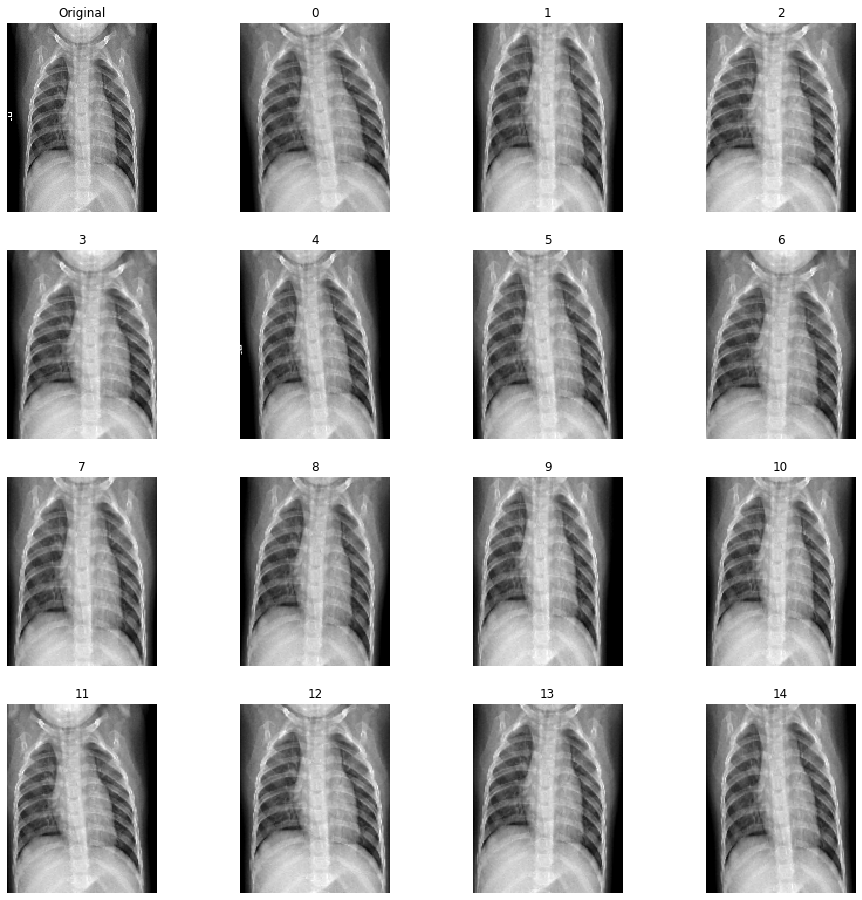

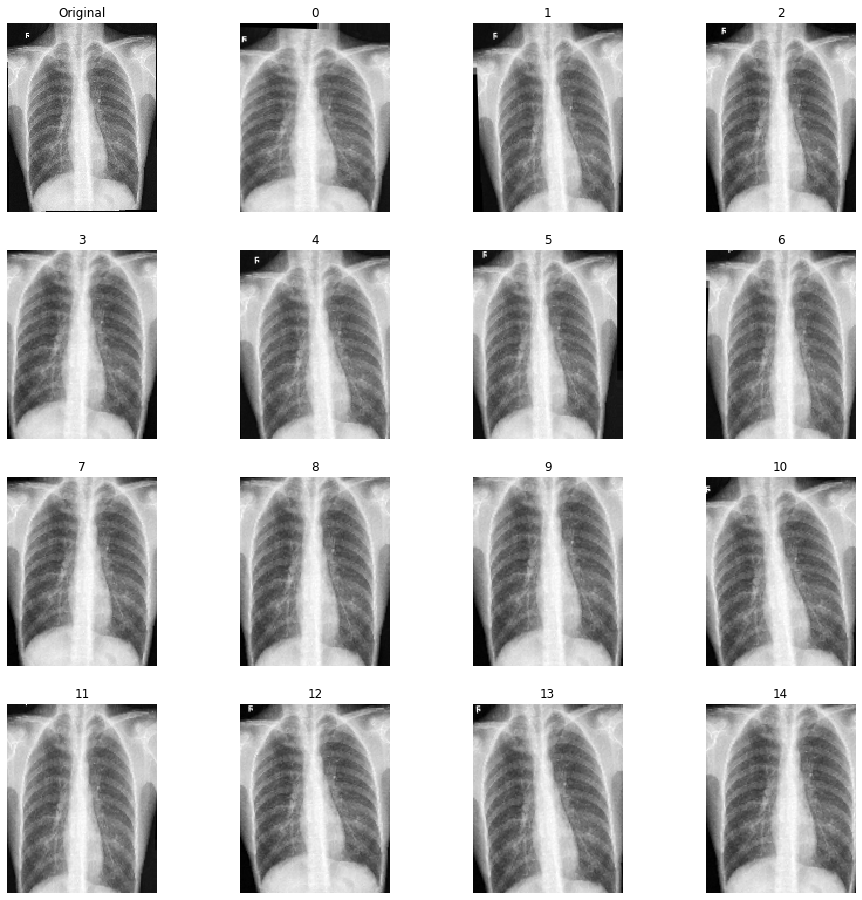

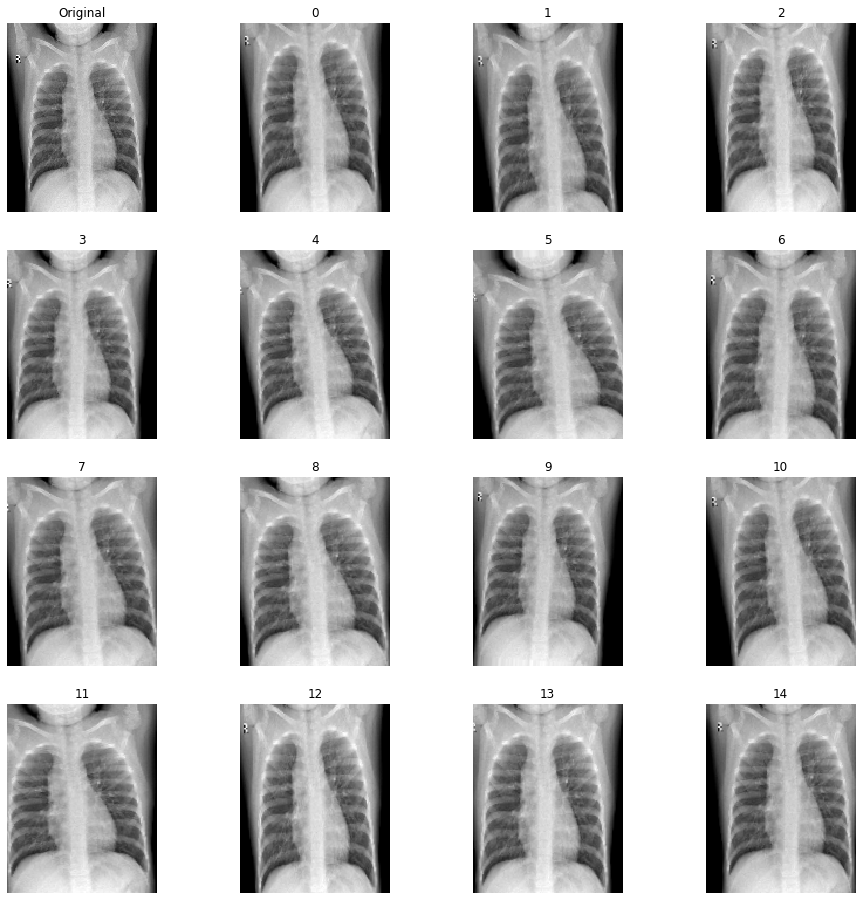

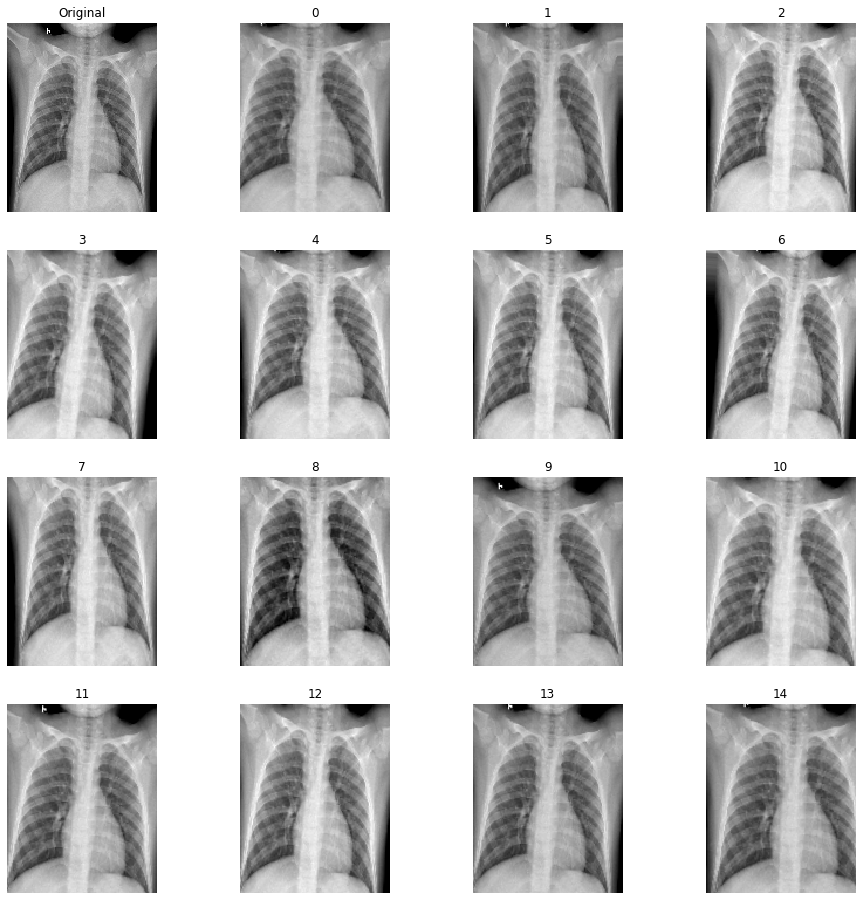

In [49]:
pltsize=4
row_images = 4
col_images = 4

# Create a transformed data generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=5,
    width_shift_range=0.05,
    zoom_range=[0.8, 1],
    height_shift_range=0.05,
    horizontal_flip=False)

# fit parameters from data
datagen.fit(X_resampled_data_gray_lenet)

for idx in range(0, 4):
    # Plot the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    plt.imshow(X_resampled_data_gray_lenet[idx].reshape(162,128)*255,cmap='gray')
    plt.title("Original")

    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_resampled_data_gray_lenet[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(rand_trans.reshape(162,128)*255,cmap='gray')
        plt.title(i)

    plt.show()                             

In [50]:
X_resampled_train_gray_lenet, X_resampled_valid_gray_lenet, y_resampled_train, y_resampled_valid = train_test_split(X_resampled_data_gray_lenet, y_resampled_data, random_state=0, test_size = 0.2, train_size = 0.8)

In [51]:
y_resampled_train_num = y_train_encoder.fit_transform(y_resampled_train)
y_resampled_train_wide = keras.utils.to_categorical(y_resampled_train_num, num_classes)

y_resampled_valid_num = y_train_encoder.fit_transform(y_resampled_valid)
y_resampled_valid_wide = keras.utils.to_categorical(y_resampled_valid_num, num_classes)

#### Lenet-5 model definition

In [52]:
model_aug = Sequential()
model_aug.add(Conv2D(6, (5, 5),input_shape=(162,128,1)))
model_aug.add(Activation('relu'))
model_aug.add(AveragePooling2D(pool_size=(2, 2), strides=2))

model_aug.add(Conv2D(16, (5,5)))
model_aug.add(Activation('relu'))
model_aug.add(AveragePooling2D(pool_size=(2, 2), strides=2))

model_aug.add(Conv2D(120, (5,5)))
model_aug.add(Activation('relu'))

model_aug.add(Flatten())
model_aug.add(Dense(84))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

model_aug.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 158, 124, 6)       156       
_________________________________________________________________
activation_6 (Activation)    (None, 158, 124, 6)       0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 79, 62, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 58, 16)        2416      
_________________________________________________________________
activation_7 (Activation)    (None, 75, 58, 16)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 37, 29, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 25, 120)      

In [53]:
batch_size = 128
epochs = 200

# Set up the callback to save the best model based on validation data
best_weights_filepath_aug = './best_weights_lenet5_aug.hdf5'
mcp_aug = ModelCheckpoint(best_weights_filepath_aug, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trainning data
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=5,
    width_shift_range=0.05,
    zoom_range=[0.8, 1],
    height_shift_range=0.05,
    horizontal_flip=False)
datagen_train.fit(X_resampled_train_gray_lenet)
        
history_aug = model_aug.fit_generator(datagen_train.flow(X_resampled_train_gray_lenet, y_resampled_train_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train) / batch_size,
          validation_data=(X_resampled_valid_gray_lenet, y_resampled_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp_aug])

#reload best weights
model_aug.load_weights(best_weights_filepath_aug)

Epoch 1/200
33/32 [==============================] - 19s 566ms/step - loss: 0.6157 - accuracy: 0.6540 - val_loss: 0.2662 - val_accuracy: 0.8944
Epoch 2/200
33/32 [==============================] - 19s 573ms/step - loss: 0.3638 - accuracy: 0.8612 - val_loss: 0.2158 - val_accuracy: 0.9111
Epoch 3/200
33/32 [==============================] - 19s 570ms/step - loss: 0.2642 - accuracy: 0.9043 - val_loss: 0.2697 - val_accuracy: 0.8926
Epoch 4/200
33/32 [==============================] - 19s 561ms/step - loss: 0.2420 - accuracy: 0.9121 - val_loss: 0.2755 - val_accuracy: 0.8778
Epoch 5/200
33/32 [==============================] - 19s 561ms/step - loss: 0.2337 - accuracy: 0.9114 - val_loss: 0.3029 - val_accuracy: 0.8963
Epoch 6/200
33/32 [==============================] - 18s 559ms/step - loss: 0.2089 - accuracy: 0.9171 - val_loss: 0.1665 - val_accuracy: 0.9315
Epoch 7/200
33/32 [==============================] - 19s 573ms/step - loss: 0.1892 - accuracy: 0.9281 - val_loss: 0.1806 - val_accuracy:

#### Evaluation

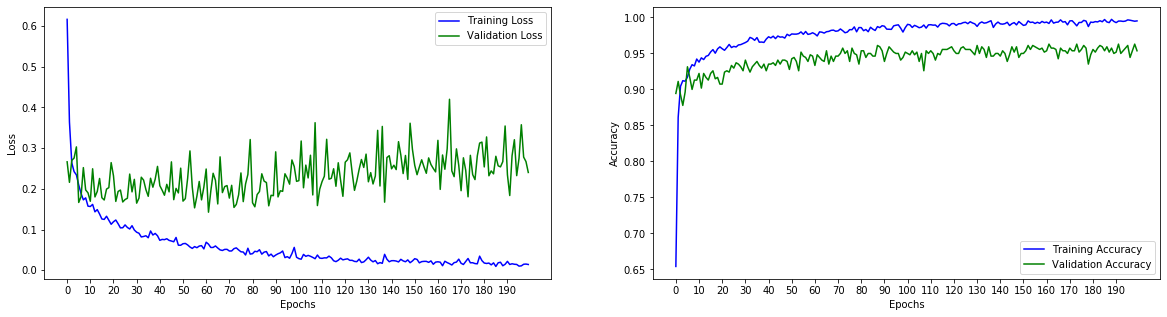

In [54]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

acc=history_aug.history['accuracy']
val_acc=history_aug.history['val_accuracy']

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::10])
plt.legend()

plt.subplot(1,2,2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, 'blue', label='Training Accuracy')
plt.plot(val_acc, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::10])
plt.legend()

plt.show()

In [55]:
#Show performance on the training set
predict_train_aug = model_aug.predict_classes(X_resampled_train_gray_lenet) 
accuracy_train_aug = accuracy_score(y_resampled_train_num, predict_train_aug)
report_train_aug = metrics.classification_report(y_resampled_train_num, predict_train_aug, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_train_aug)
print(' ')
print(metrics.classification_report(y_resampled_train_num, predict_train_aug))
print("Confusion matrix")
print(metrics.confusion_matrix(y_resampled_train_num, predict_train_aug))

Accuracy:  0.9805375347544022
 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1072
           1       1.00      0.96      0.98      1086

    accuracy                           0.98      2158
   macro avg       0.98      0.98      0.98      2158
weighted avg       0.98      0.98      0.98      2158

Confusion matrix
[[1069    3]
 [  39 1047]]


In [56]:
#Show performance on the validation set
predict_valid_aug = model_aug.predict_classes(X_resampled_valid_gray_lenet) 
accuracy_valid_aug = accuracy_score(y_resampled_valid_num, predict_valid_aug)
report_valid_aug = metrics.classification_report(y_resampled_valid_num, predict_valid_aug, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_valid_aug)
print(' ')
print(metrics.classification_report(y_resampled_valid_num, predict_valid_aug))
print("Confusion matrix")
print(metrics.confusion_matrix(y_resampled_valid_num, predict_valid_aug))

Accuracy:  0.9481481481481482
 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       277
           1       0.97      0.92      0.95       263

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540

Confusion matrix
[[269   8]
 [ 20 243]]


In [57]:
predict_test_aug = model_aug.predict_classes(X_test_gray_lenet)

accuracy_test_aug = accuracy_score(y_test_num, predict_test_aug)
report_aug = metrics.classification_report(y_test_num, predict_test_aug, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_test_aug)
print(' ')
print(metrics.classification_report(y_test_num, predict_test_aug))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, predict_test_aug))

Accuracy:  0.9118589743589743
 
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       234
           1       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624

Confusion matrix
[[192  42]
 [ 13 377]]


Print a few correctly classified images

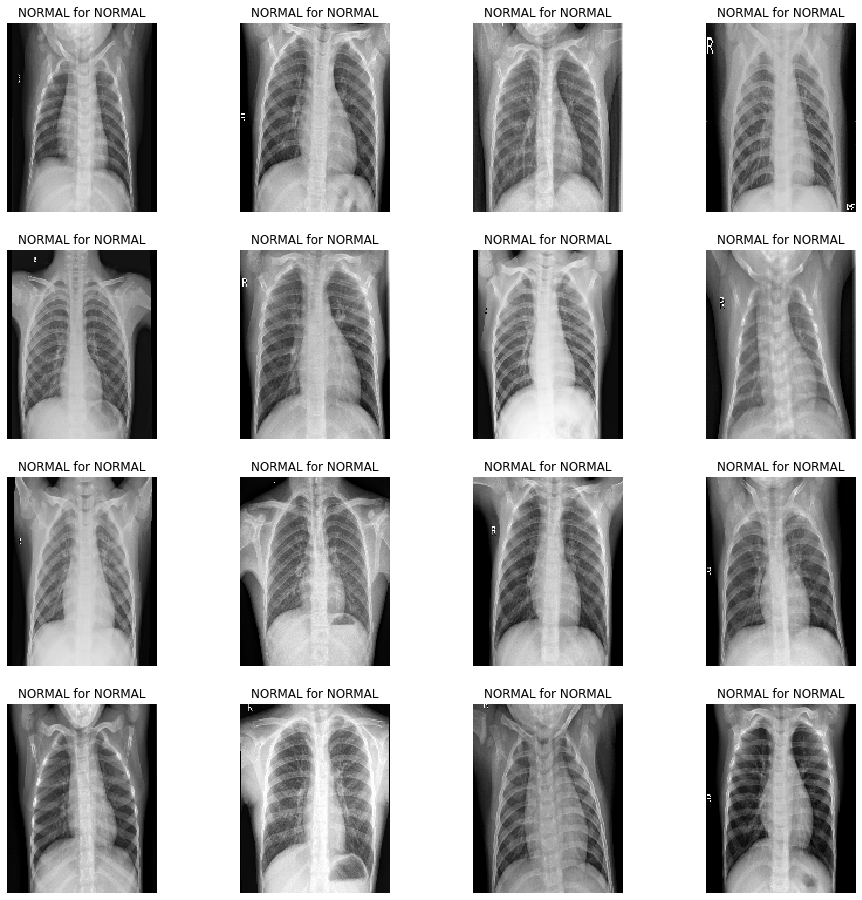

In [58]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_aug.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_gray.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test_gray[i],cmap='gray')
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

Print a few misclassified images

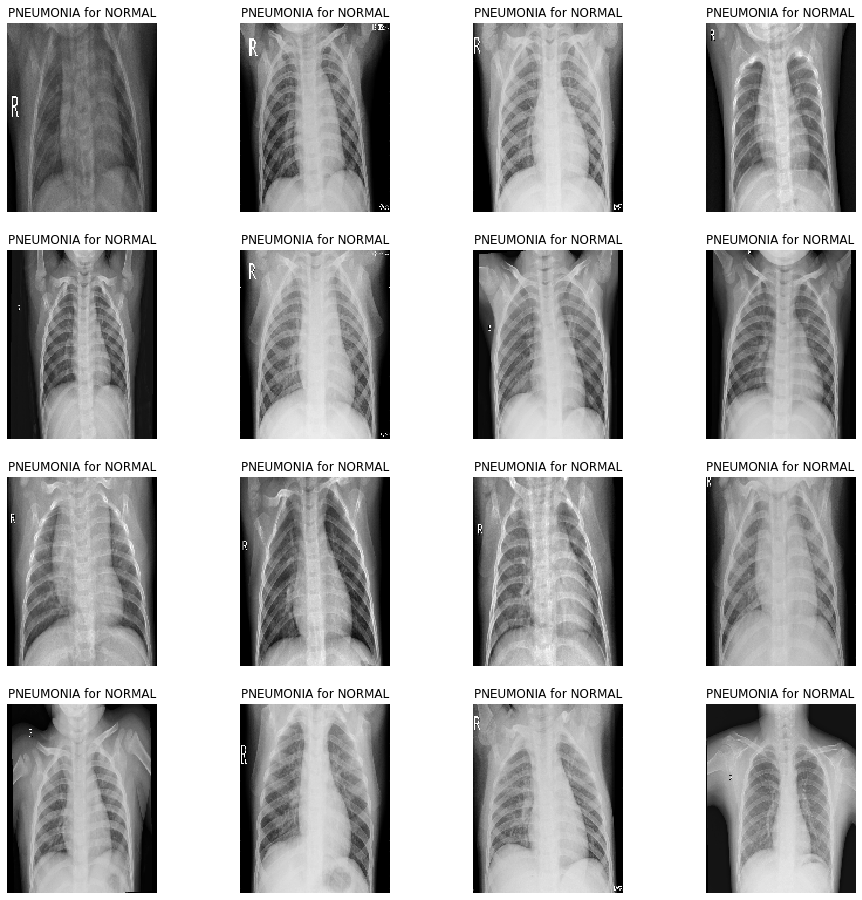

In [59]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_aug.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_gray.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test_gray[i]*255,cmap='gray')
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

In [60]:
df['LeNet with Data Augmentation']['Accuracy'] = accuracy_test_aug
df['LeNet with Data Augmentation']['Precision'] = report_aug['macro avg']['precision']
df['LeNet with Data Augmentation']['Recall'] = report_aug['macro avg']['recall']
df['LeNet with Data Augmentation']['F1-score'] = report_aug['macro avg']['f1-score']

In [61]:
df

Logistic Regression  LeNet with Undersampling  \
Accuracy              0.745192                  0.733974   
Precision             0.832650                  0.825874   
Recall                0.663675                  0.648718   
F1-score              0.663819                  0.643772   

           LeNet with Data Augmentation  VGG-16  
Accuracy                       0.911859     0.0  
Precision                      0.918173     0.0  
Recall                         0.893590     0.0  
F1-score                       0.903365     0.0

## Task 5 - VGG16 Model

Load the vgg-16 model with trained on imagenet, to use the bottleneck features for our classification task.

In [62]:
keras.backend.clear_session()

In [63]:
vgg16_model = keras.applications.VGG16(weights='imagenet', input_shape = X_train[0].shape, include_top=False)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [64]:
vgg16_last_layer = vgg16_model.output

x1 = Flatten()(vgg16_last_layer)
x2 = Dense(84, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

full_model = keras.Model(vgg16_model.input, final_layer)

#full_model.layers[-1].set_weights(old_model.layers[-1].get_weights())

for layer in full_model.layers[:17]: #freeze the last 16 layers, except the final convolution layer
    layer.trainable = False

full_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

The full model is as shown above, with the last convolution layer and the dense layers unfrozen for training ie., parameters that are trainable are 3220189.

In [65]:
X_train_resampled_rgb, X_valid_resampled_rgb, y_train_resampled_rgb, y_valid_resampled_rgb = train_test_split(X_resampled_data_rgb, y_resampled_data, random_state=0, test_size = 0.20, train_size = 0.80)

In [66]:
y_train_resampled_rgb_num = y_train_encoder.fit_transform(y_train_resampled_rgb)
y_train_resampled_rgb_wide = keras.utils.to_categorical(y_train_resampled_rgb_num, num_classes)

y_valid_resampled_rgb_num= y_train_encoder.fit_transform(y_valid_resampled_rgb)
y_valid_resampled_rgb_wide = keras.utils.to_categorical(y_valid_resampled_rgb_num, num_classes)

In [67]:
batch_size = 128
epochs = 200

best_weights_filepath_vgg = './best_weights_vgg16.hdf5'
mcp_vgg = ModelCheckpoint(best_weights_filepath_vgg, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=5,
    width_shift_range=0.05,
    zoom_range=[0.8, 1],
    height_shift_range=0.05,
    horizontal_flip=False)
datagen_train.fit(X_train_resampled_rgb)

history_vgg = full_model.fit(datagen_train.flow(X_train_resampled_rgb, y_train_resampled_rgb_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train_resampled_rgb) / batch_size,
          validation_data=(X_valid_resampled_rgb, y_valid_resampled_rgb_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp_vgg])

full_model.load_weights(best_weights_filepath_vgg)

Epoch 1/200
17/16 [==============================] - 102s 6s/step - loss: 0.5548 - accuracy: 0.8309 - val_loss: 0.2046 - val_accuracy: 0.9000
Epoch 2/200
17/16 [==============================] - 101s 6s/step - loss: 0.1810 - accuracy: 0.9365 - val_loss: 0.2470 - val_accuracy: 0.9111
Epoch 3/200
17/16 [==============================] - 100s 6s/step - loss: 0.1641 - accuracy: 0.9449 - val_loss: 0.1504 - val_accuracy: 0.9296
Epoch 4/200
17/16 [==============================] - 101s 6s/step - loss: 0.1347 - accuracy: 0.9486 - val_loss: 0.3288 - val_accuracy: 0.8907
Epoch 5/200
17/16 [==============================] - 101s 6s/step - loss: 0.1084 - accuracy: 0.9592 - val_loss: 0.2409 - val_accuracy: 0.9259
Epoch 6/200
17/16 [==============================] - 100s 6s/step - loss: 0.1072 - accuracy: 0.9606 - val_loss: 0.1471 - val_accuracy: 0.9370
Epoch 7/200
17/16 [==============================] - 101s 6s/step - loss: 0.0882 - accuracy: 0.9671 - val_loss: 0.2027 - val_accuracy: 0.9315
Epoch 

### Evaluation

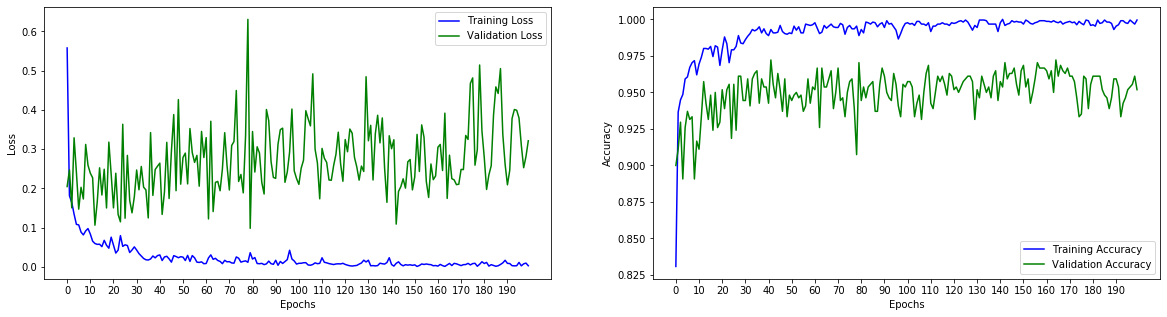

In [68]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

acc=history_vgg.history['accuracy']
val_acc=history_vgg.history['val_accuracy']

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::10])
plt.legend()

plt.subplot(1,2,2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, 'blue', label='Training Accuracy')
plt.plot(val_acc, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::10])
plt.legend()

plt.show()

In [69]:
#Show performance on the training set
predict_train_vgg = np.argmax(full_model.predict(X_train_resampled_rgb),axis=1)   
accuracy_train_vgg = accuracy_score (y_train_resampled_rgb, predict_train_vgg)
report_train_vgg = metrics.classification_report(y_train_resampled_rgb, predict_train_aug, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_train_vgg)
print(' ')
print(metrics.classification_report(y_train_resampled_rgb, predict_train_vgg))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_resampled_rgb, predict_train_vgg))

Accuracy:  0.9986098239110287
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1072
           1       1.00      1.00      1.00      1086

    accuracy                           1.00      2158
   macro avg       1.00      1.00      1.00      2158
weighted avg       1.00      1.00      1.00      2158

Confusion matrix
[[1072    0]
 [   3 1083]]


In [70]:
#Show performance on the validation set
predict_valid_vgg = np.argmax(full_model.predict(X_valid_resampled_rgb),axis=1)   
accuracy_valid_vgg = accuracy_score (y_valid_resampled_rgb, predict_valid_vgg)
report_valid_vgg = metrics.classification_report(y_valid_resampled_rgb, predict_valid_aug, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_valid_vgg)
print(' ')
print(metrics.classification_report(y_valid_resampled_rgb, predict_valid_vgg))
print("Confusion matrix")
print(metrics.confusion_matrix(y_valid_resampled_rgb, predict_valid_vgg))

Accuracy:  0.9703703703703703
 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       277
           1       0.98      0.96      0.97       263

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540

Confusion matrix
[[271   6]
 [ 10 253]]


In [71]:
predict_test_vgg = np.argmax(full_model.predict(X_test),axis=1)

accuracy_test_vgg = accuracy_score(y_test_num, predict_test_vgg)
report_vgg = metrics.classification_report(y_test_num, predict_test_vgg, output_dict=True)

# Print performance details
print('Accuracy: ', accuracy_test_vgg)
print(' ')
print(metrics.classification_report(y_test_num, predict_test_vgg))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, predict_test_vgg))

Accuracy:  0.9134615384615384
 
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       234
           1       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624

Confusion matrix
[[188  46]
 [  8 382]]


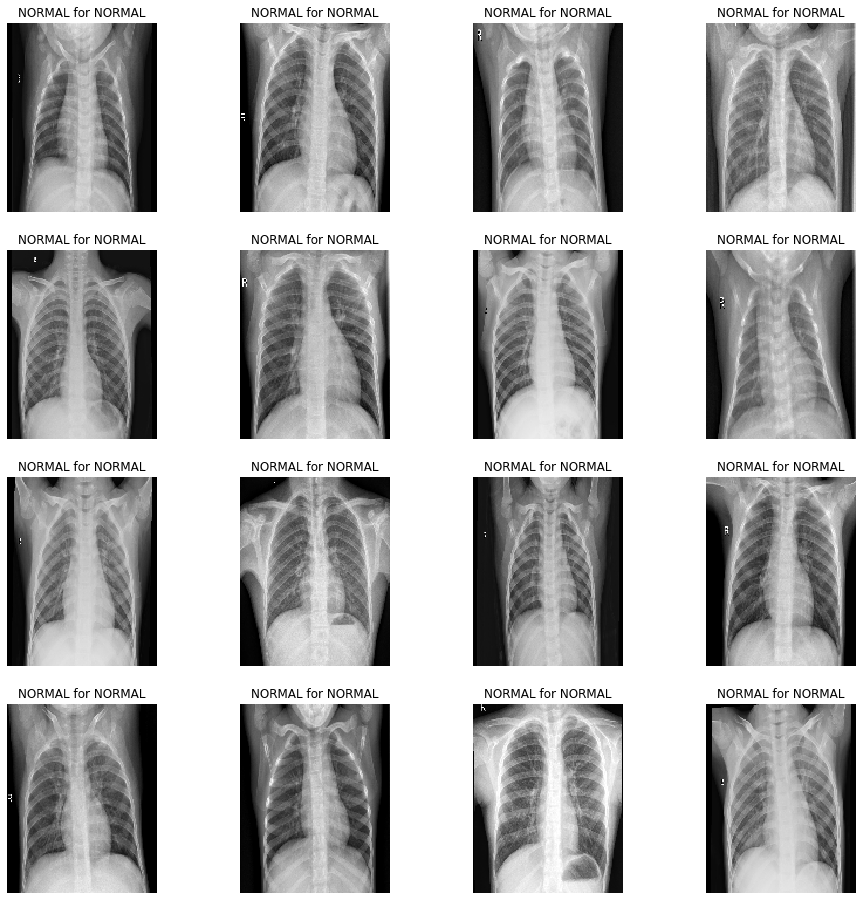

In [72]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_vgg.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(Image.fromarray((X_test[i]*255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

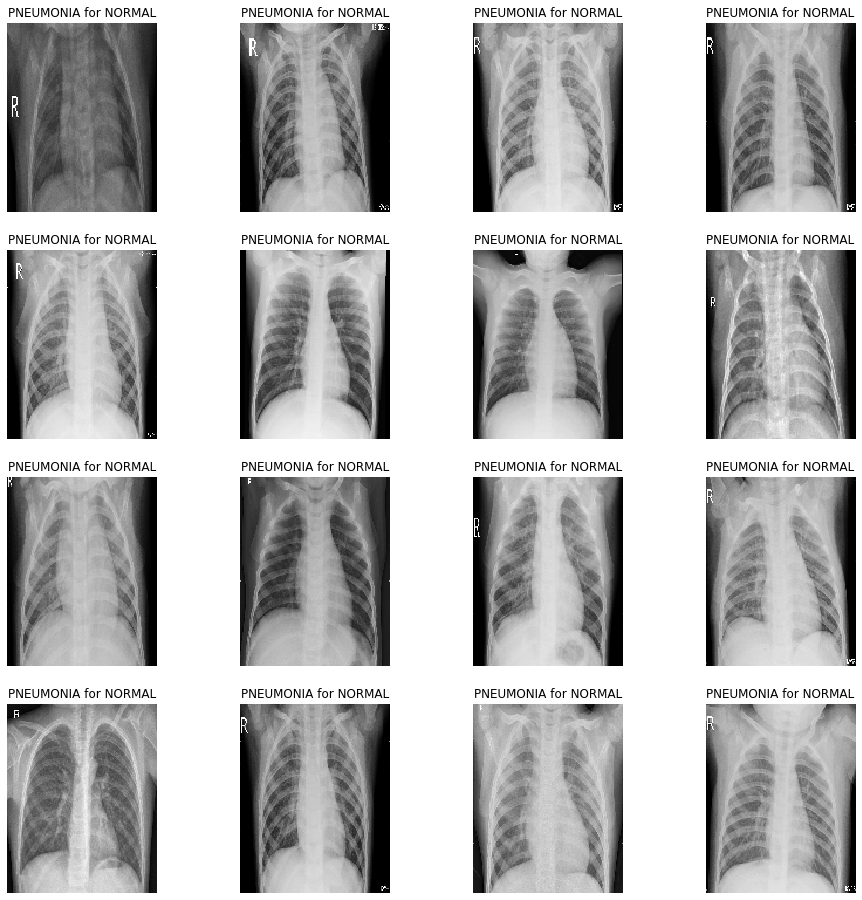

In [73]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = predict_test_vgg.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(Image.fromarray((X_test[i]*255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], classes_num_label[y_test_num[i]]))
        ii = ii + 1

In [74]:
df['VGG-16']['Accuracy'] = accuracy_test_vgg
df['VGG-16']['Precision'] = report_vgg['macro avg']['precision']
df['VGG-16']['Recall'] = report_vgg['macro avg']['recall']
df['VGG-16']['F1-score'] = report_vgg['macro avg']['f1-score']

## Task 6 - Comparison of 4 Models

The models implemented for pneumonia detection were:
1.	Logistic regression model 
2.	Convolutional neural network with a standard LeNet-5 architecture
3.	LeNet-5 architecture with data augmentation,
4.	VGG-16 model with data augmentation. 

The table below presents the results for the test set for each model. For a fair comparison, all CNN models were trained for 200 epochs and the best weights with highest validation loss are loaded for the final model.The ADAM optimizer of accuracy optimization with binary cross-entropy for loss function was used for all the models.

In [75]:
# print the dataframe with the evaluation methods compared for the four models applied to the test set
df

Logistic Regression  LeNet with Undersampling  \
Accuracy              0.745192                  0.733974   
Precision             0.832650                  0.825874   
Recall                0.663675                  0.648718   
F1-score              0.663819                  0.643772   

           LeNet with Data Augmentation    VGG-16  
Accuracy                       0.911859  0.913462  
Precision                      0.918173  0.925854  
Recall                         0.893590  0.891453  
F1-score                       0.903365  0.904202

For the Logistic Regression, the images were converted into single-channel greyscale images by averaging the channels and flattened the images prior to training. The recall, precision and f1-score indicate that this model is biased towards the majority class (pneumonia). Moreover, the model works very well on the validation set, but does not work well on the test set, indicating that the training set is unrepresentative of the x-ray images in the test data . This model was also the least computational expensive.

Thus, to address the imbalanced classes, we undersampled the majority class in the training set prior to training the LeNet-5 model. We observed that the evaluation scores chosen improved when using the LeNet-5 architecture with slightly less bias towards the majority class. 

Therefore, to improve the LeNet model and tackle the issue that the training data did not capture all the possibilities encountered in the test set, we have used data augmentation (slight rotation and zooming). As expected, the evaluation measurements improved. Accuracy and f1-score are higher with no bias towards any one class, proving that this model is a reasonably well-performing. 

For VGG-16, with the dense layeres trained with bottleneck features from the network trained on imagenet, the results were found to not be on par with the lenet-5 model trained with an augmented dataset. Therefore, we tried unfreezing the last convolution layer (of block 5) and training. This method was found to perform best. However, the performance of the VGG-16 could be improved by training for all the weights from scratch as it a deeper network with more options for learning optimal features for the task in the convolutional layers, but it is very computationally expensive

The VGG-16 is a more computationally expensive model, even with pre-trained weights, since it has more convolutional layers and parameters compared to LeNet-5. When making the trade-off between run-time and performance, the LeNet can be a better choice. But if run-time and power is not an issue, the VGG-16 is a powerful model. However, data augmentation proved to be the best option. A few adjustments to the images proved to be extremely helpful to improve model performance, independent of the type of architecture.